In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
import random


def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

In [3]:
import datetime
import traceback
from torch.utils.data import Dataset, DataLoader

def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0, 
                    plot=False):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

# Dynamic plot
    if plot:
        plot_epoch_data = []
        plot_train_loss = []
        plot_val_loss = []

        fig, ax = plt.subplots()
        line_train, = ax.plot([], [], 'r-')
        line_val, = ax.plot([], [], 'b-')
        ax.legend(['train', 'val'])
        ax.set_xlim(0, epoch_n)

        def add_point(epoch_i, train_loss, val_loss):
            max_loss = max(ax.viewLim.y1 / 1.1, train_loss, val_loss)
            ax.set_ylim(0, max_loss * 1.1)
            
            plot_epoch_data.append(epoch_i)
            plot_train_loss.append(train_loss)
            plot_val_loss.append(val_loss)
            line_train.set_data(plot_epoch_data, plot_train_loss)
            line_val.set_data(plot_epoch_data, plot_val_loss)
            clear_output(wait=True)
            display(fig)


    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            

            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break


                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    # print(batch_x.shape, pred.shape, batch_y.shape)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n

            if plot:
                add_point(epoch_i, mean_train_loss, mean_val_loss)
            else:
                pass
            
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель! На эпохе {}'.format(epoch_i))
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
        finally:
            if plot:
                plt.close(fig)

    return best_val_loss, best_model

In [4]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        model.train()
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [5]:
class TestDataset(Dataset):
    def __init__(self, data: pd.DataFrame, dict_vectorizer):
        self.X = data.drop(columns=["char"])
        self.y = data["char"]
        self.dict_vectorizer = dict_vectorizer
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return [self.X.iloc[index].to_numpy().astype(np.float32), self.dict_vectorizer[self.y.iloc[index]]]

In [6]:
df = pd.read_csv("data.csv")
df.dtypes

0       float64
1       float64
2       float64
3       float64
4       float64
         ...   
198     float64
199     float64
200     float64
201     float64
char     object
Length: 203, dtype: object

In [ ]:
df.shape

(600, 203)

In [8]:
df["char"].value_counts()

char
f    50
h    50
i    50
l    50
m    50
o    50
q    50
s    50
t    50
y    50
z    50
~    50
Name: count, dtype: int64

In [9]:
# make dict for all chars
char_dict = {char: i for i, char in enumerate(df["char"].unique())}
char_dict

{'f': 0,
 'h': 1,
 'i': 2,
 'l': 3,
 'm': 4,
 'o': 5,
 'q': 6,
 's': 7,
 't': 8,
 'y': 9,
 'z': 10,
 '~': 11}

In [10]:
df.shape

(600, 203)

In [13]:
example = pd.read_csv("exampleData.csv")

example_dataset = TestDataset(example, char_dict)

In [14]:
from sklearn.model_selection import train_test_split

# split data by "char" column to train, test and validation
train, test = train_test_split(df, test_size=0.2, stratify=df["char"])
test, val = train_test_split(test, test_size=0.5, stratify=test["char"])

In [15]:
train = pd.concat([train, example], ignore_index=True)

In [16]:
train_dataset = TestDataset(train, char_dict)
test_dataset = TestDataset(test, char_dict)
val_dataset = TestDataset(val, char_dict)

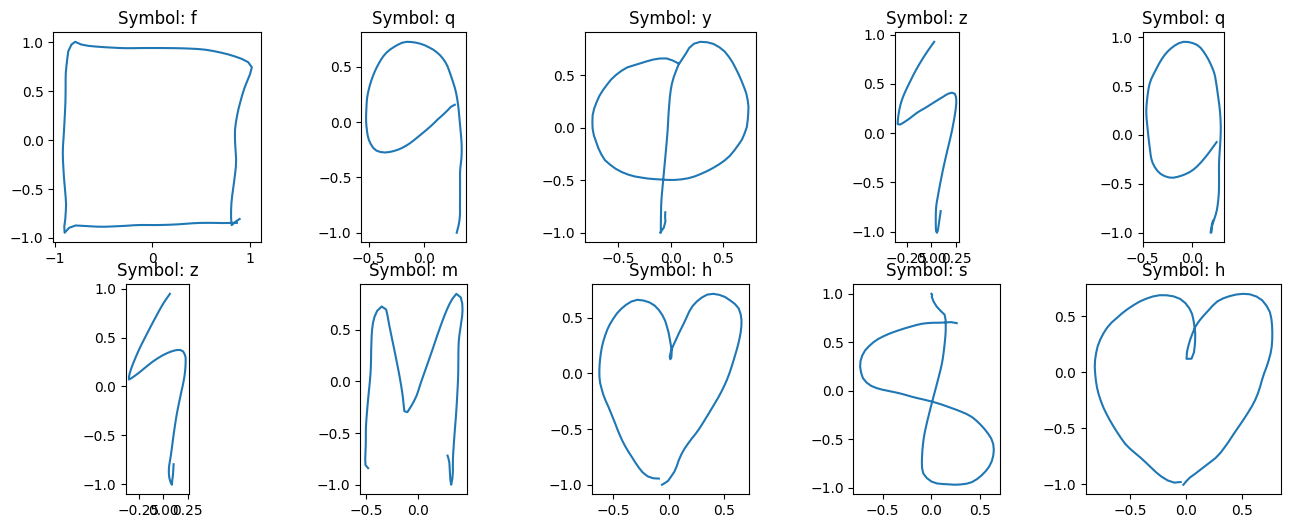

In [27]:
fig = plt.figure(figsize=(16, 6))
axs = fig.subplots(2, 5).flatten()

# plot y_wrong and y_preds_wrong X_wrong
for i in range(10):
    data = train_dataset[random.randint(0, len(train_dataset)-1)]
    plot_2d(data[0], axs[i])
    axs[i].set_title(f"Symbol: {list(char_dict.keys())[list(char_dict.values()).index(data[1])]}")
    # axs[i].set_title(f"True: {list(char_dict.keys())[list(char_dict.values()).index(y_wrong[i])]}, Pred: {list(char_dict.keys())[list(char_dict.values()).index(y_preds_wrong[i])]}")

In [27]:
print(train_dataset.__len__(), test_dataset.__len__(), val_dataset.__len__())

492 60 60


In [ ]:
class TestRegr(nn.Module):
    def __init__(self):
        super(TestRegr, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(202, 101),
            nn.Sigmoid(),
            nn.Linear(101, 50),
            nn.Sigmoid(),
            nn.Linear(50, 25),
            nn.Sigmoid(),
            nn.Linear(25, 20),
            nn.Sigmoid(),
            nn.Linear(25, 12)
        )

    def forward(self, X_batch):
        return self.layers(X_batch)

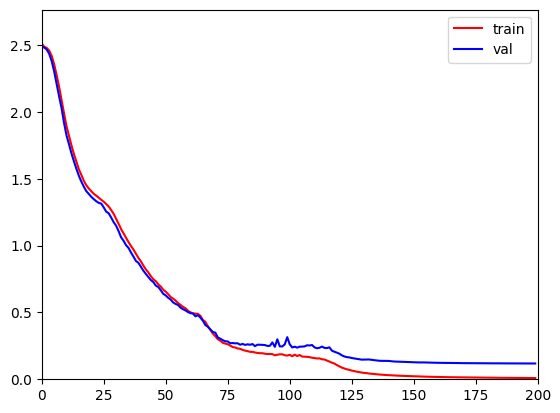

Среднее значение функции потерь на валидации 0.11801449209451675
Новая лучшая модель! На эпохе 199



(0.11801449209451675,
 TestRegr(
   (layers): Sequential(
     (0): Linear(in_features=202, out_features=101, bias=True)
     (1): Sigmoid()
     (2): Linear(in_features=101, out_features=50, bias=True)
     (3): Sigmoid()
     (4): Linear(in_features=50, out_features=25, bias=True)
     (5): Sigmoid()
     (6): Linear(in_features=25, out_features=20, bias=True)
     (7): Sigmoid()
     (8): Linear(in_features=20, out_features=12, bias=True)
   )
 ))

In [34]:
# train model 
model = TestRegr()
init_random_seed(0)

train_eval_loop(model, train_dataset, test_dataset, nn.CrossEntropyLoss(), lr=1e-2, epoch_n=200, batch_size=128, device='cpu', plot=True)

Time: 1017600.000


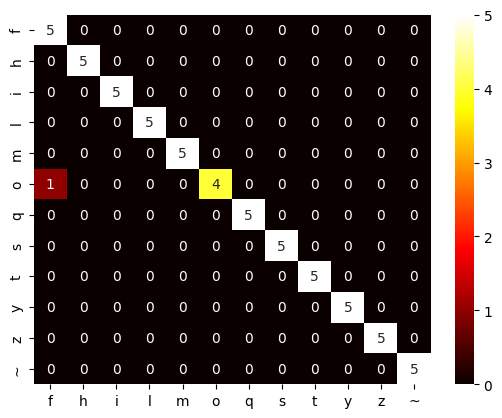

In [36]:
import seaborn as sns
import time

data_to_check = val

model.eval()
t1 = time.perf_counter_ns()
with torch.no_grad():
    y_preds = model(torch.Tensor(data_to_check.drop(columns=["char"]).to_numpy().astype(np.float32)))
    y_preds = y_preds.detach().numpy().argmax(axis=1)
    y = data_to_check["char"].map(char_dict).to_numpy()
t2 = time.perf_counter_ns()
print("Time: {:.3f}".format(t2-t1))

# confusion matrix as heatmap with numbers
from sklearn.metrics import confusion_matrix
confusionMatrinx = confusion_matrix(y, y_preds)

sns.heatmap(confusionMatrinx, annot=True, fmt="d", cmap='hot', xticklabels=char_dict.keys(), yticklabels=char_dict.keys())
plt.show()

In [19]:
def plot_2d(data, axs = None):
    x = data[0::2]
    y = data[1::2]

    if axs:
        axs.plot(x, y)
        axs.set_aspect('equal')
    else:
        plt.plot(x, y)
        plt.gca().set_aspect('equal', adjustable='box')

In [37]:
data_to_check = example

model.eval()
with torch.no_grad():
    y_preds = model(torch.Tensor(data_to_check.drop(columns=["char"]).to_numpy().astype(np.float32)))
    y_preds = y_preds.detach().numpy().argmax(axis=1)
    y = data_to_check["char"].map(char_dict).to_numpy()

y_wrong = y[y_preds != y]
y_preds_wrong = y_preds[y_preds != y]
X_wrong = data_to_check[data_to_check["char"].map(char_dict).isin(y_wrong)]

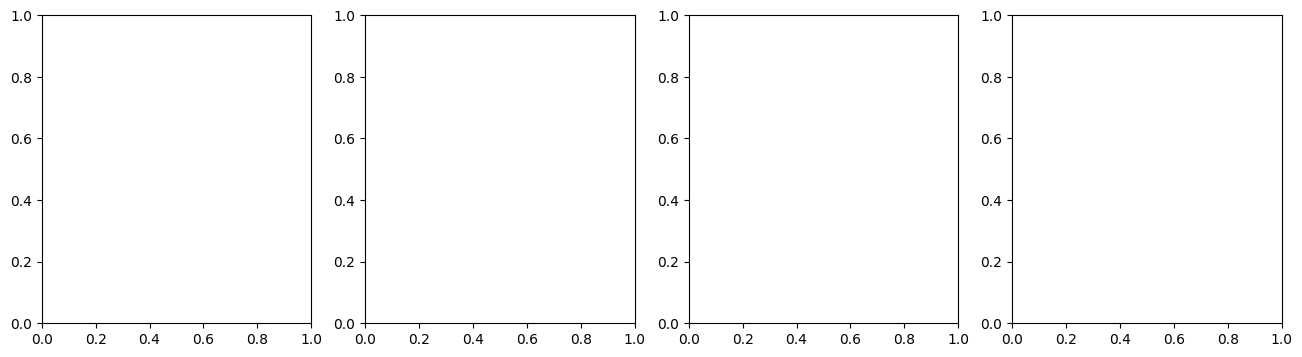

In [38]:
fig = plt.figure(figsize=(16, 4))
axs = fig.subplots(1, 4).flatten()

# plot y_wrong and y_preds_wrong X_wrong
for i in range(y_wrong.shape[0]):
    plot_2d(X_wrong.drop(columns=["char"]).reset_index(drop=True).loc[i], axs[i])
    axs[i].set_title(f"True: {list(char_dict.keys())[list(char_dict.values()).index(y_wrong[i])]}, Pred: {list(char_dict.keys())[list(char_dict.values()).index(y_preds_wrong[i])]}")

In [59]:
import os
os.chdir("/mnt/c/Users/MrCre/Desktop/dev/SymbolicaNN")

In [39]:
torch.save(model, "./model_v1_examples.pt")
torch.save(model.state_dict(), "./model_v1_examples_state_dict.pt")